In [165]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from synthpop.models import AxtellModel
from synthpop.infer import Infer, VI
from synthpop.generative import MaskedAutoRegressiveFlow
import pygtc

In [167]:
model = AxtellModel(N=1000, v=1)

def loss(x):
    ts, ass, _, efforts = x
    init_mean_efforts = efforts[0].mean()
    previous_efforts = efforts[0].copy()
    for i in range(len(ts) - 1):
        agent = ass[i+1]
        previous_efforts = model.reconstruct_effort(previous_efforts, agent, efforts[i+1])
    return torch.tensor((previous_efforts.mean() - init_mean_efforts) + 1)

class MetaGenerator(MaskedAutoRegressiveFlow):
    param_min = torch.tensor([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1., 1e-3, 1e-3])
    param_max = torch.tensor([2., 2, 2, 2, 2, 1, 4, 5, 5])
    def forward(self, generator_params=None):
        if generator_params is None:
            generator_params = self.sample(1)[0][0]
        def generator(n_agents):
            params = 10 ** generator_params
            params = torch.maximum(self.param_min, params)
            params = torch.minimum(self.param_max, params)
            E_a, E_b, T_a, T_b, P_k, P_t, beta, a, b = params
            # Draw effort levels
            es  = np.random.beta(E_a, E_b, size=n_agents)
            # Draw preferences
            ths = np.random.beta(T_a, T_b, size=n_agents)
            # Draw rates
            #P_k = torch.clamp(P_k, min=0, max=4)
            #P_t = torch.clamp(P_t, min=1, max=4)
            phs = np.random.gamma(P_k, P_t, size=n_agents) 
            return es, ths, phs, beta.item(), a.item(), b.item()
        return generator

prior = torch.distributions.Independent(torch.distributions.Uniform(torch.tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]),
                                    torch.tensor([2., 2, 2, 2, 2, 1, 4, 5, 5])), reinterpreted_batch_ndims=1)

#meta_generator = MetaGenerator(torch.nn.Parameter(prior.sample()), torch.nn.Parameter(0.2 * torch.eye(9)))

In [186]:
#meta_generator = MetaGenerator(torch.nn.Parameter(prior.sample()), torch.nn.Parameter(0.2 * torch.eye(9)))
meta_generator = MetaGenerator(n_parameters = 9, n_hidden_units = 64, n_transforms = 8)
inff = 1000
prior_vi = torch.distributions.Independent(torch.distributions.Uniform(-inff * torch.ones(9), inff * torch.ones(9)), 1)
infer = Infer(model=model, meta_generator=meta_generator, prior=prior_vi, loss=loss)
optimizer = torch.optim.AdamW(meta_generator.parameters(), lr=1e-3)
infer_method = VI(w=1, n_samples_per_epoch=10, optimizer=optimizer, 
                    progress_bar=True, progress_info=True, gradient_estimation_method="score", log_tensorboard=True)
trained_meta_generator = infer.fit(infer_method, n_epochs=1000, max_epochs_without_improvement=50)

 18%|█▊        | 183/1000 [02:26<10:52,  1.25it/s, loss=0.62, reg=inf, total=inf, best loss=51.94, epochs since improv.=50]   


In [169]:
trained_meta_generator = meta_generator

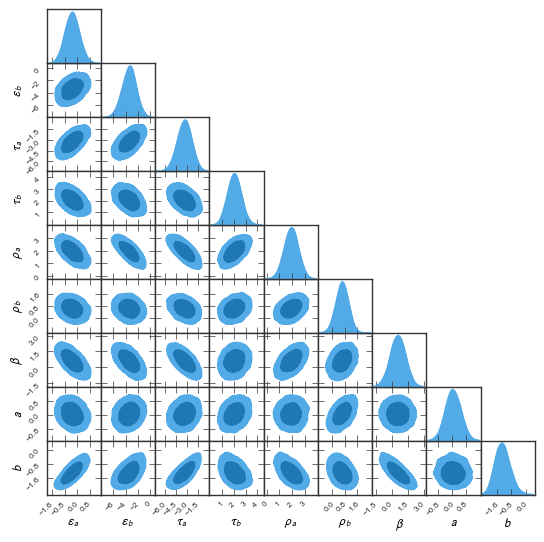

In [164]:
with torch.no_grad():
    samples = trained_meta_generator.sample(10000)[0].numpy()
    #samples = generator(10000) #trained_meta_generator.samples.numpy()
pygtc.plotGTC([samples], 
              nContourLevels=2, 
              paramNames=[r"$\epsilon_a$", r"$\epsilon_b$",
                        r"$\tau_a$", r"$\tau_b$",
                        r"$\rho_a$", r"$\rho_b$",
                        r"$\beta$", r"$a$", r"$b$"]);

In [182]:
prior.sample()

tensor([1.6902, 0.0099, 0.7680, 0.1302, 1.7773, 0.3576, 2.8300, 4.6591, 0.2705])

In [184]:
# get predicted efforts.
def get_mean_efforts(ts, ass, a_efforts):
    mean_efforts = [a_efforts[0].mean()]
    last_efforts = a_efforts[0]
    for i in range(len(ts) - 1):
        agent = ass[i+1]
        new_efforts = model.reconstruct_effort(last_efforts, agent, a_efforts[i+1])
        mean_efforts.append(new_efforts.mean())
        last_efforts = new_efforts
    return mean_efforts

prior_pred_efforts = []
post_pred_efforts = []
post_times = []
prior_times = []
n = 25
for j in range(n):
    # prior
    with torch.no_grad():
        generator = meta_generator(np.log10(prior.sample()))
        ts, ass, _, a_efforts = model(generator)
        mean_efforts= get_mean_efforts(ts, ass, a_efforts)
        prior_pred_efforts.append(mean_efforts)
        prior_times.append(ts)
        # trained
        generator = trained_meta_generator()
        ts, ass, _, a_efforts = model(generator)
        mean_efforts = get_mean_efforts(ts, ass, a_efforts)
        post_pred_efforts.append(mean_efforts)
        post_times.append(ts)

Text(0.5, 0, 'Time')

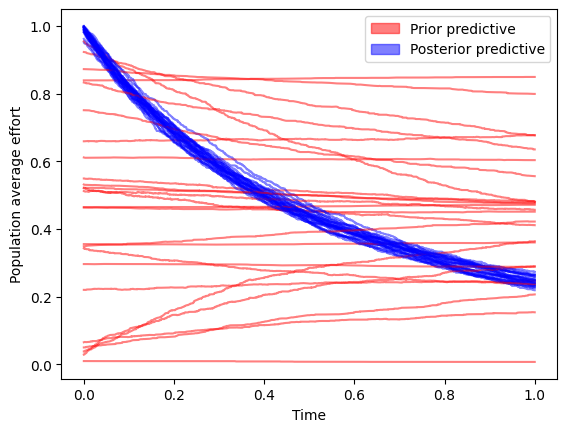

In [185]:
fig, ax = plt.subplots(1,1)
for i in range(len(post_pred_efforts)):
    ax.plot(post_times[i], post_pred_efforts[i], alpha=0.5, c='b')
    ax.plot(prior_times[i], prior_pred_efforts[i], alpha=0.5, c='r')
red_patch = mpatches.Patch(color='red', alpha=0.5, label='Prior predictive')
blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='Posterior predictive')
plt.legend(handles=[red_patch, blue_patch])
plt.ylabel("Population average effort")
plt.xlabel("Time")